# Text + All 3 Numerical Features

In [ ]:
#8 combinations in total
#based on count vectorization method

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
import re
from gensim import corpora
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import warnings
warnings.filterwarnings("ignore")

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

%matplotlib inline

# Hyperparameter tuning

# Text + "Original Average Word Length"

In [ ]:
#this is the model we selected from previous steps
#now we need to tune the model 

In [2]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [3]:
feature_df.head(2)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
0,Neutral,big group make reservation week advance,0.120370,0.055914,0.533333
1,Neutral,wait 20 minute drink another 30 breakfast not ...,0.111111,0.081413,0.285714


In [4]:
feature_df  = feature_df[['sentiment', 'cleaned_text', 'original_average_word_length']].copy()

In [5]:
feature_df.dropna(inplace = True)

In [6]:
feature_df = feature_df.sample(n=5000)

In [7]:
feature_df.sentiment.value_counts()

Poor       1707
Good       1664
Neutral    1629
Name: sentiment, dtype: int64

In [8]:
feature_df.head(1)

,sentiment,cleaned_text,original_average_word_length
218308,Poor,horrible vip lounge bottle service,0.089094


In [9]:
y = feature_df["sentiment"]

In [10]:
y[y=="Poor"] = 0
y[y=="Neutral"] = 1
y[y=="Good"] = 2

In [11]:
x = feature_df.drop(columns = ["sentiment"])

In [12]:
x.head(1)

,cleaned_text,original_average_word_length
218308,horrible vip lounge bottle service,0.089094


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [14]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 2)
y_train shape: (4000,)

x_test shape: (1000, 2)
y_test shape: (1000,)



In [15]:
y_train = list(y_train)

In [16]:
y_test = list(y_test)

In [17]:
#Count Vectors as features

In [18]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [19]:
#create df for the vectors (both train and test)

In [20]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [21]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [22]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [23]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [24]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [25]:
# Create a pipeline
pipe = Pipeline([
  ('clf', xgb.XGBClassifier(objective='multi:softmax',multilabel_ =True, num_classes = 3))
])

In [26]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
#we test four hyperparameters

search_space = [
  {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3,4,5,6],
    'clf__gamma': [0.01,0.05,0.1],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=123)
# AUC and accuracy as score
scoring = { 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='Accuracy',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
model = grid.fit(xtrain_count, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 47.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 267.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 617.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 785.8min finished


[12:32:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { multilabel_, num_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
#The running time is very long

In [27]:
predict = model.predict(xvalid_count)

print('Accuracy: {}'.format(accuracy_score(y_test, predict)))
print(confusion_matrix(y_test,predict)) # we also created a confusion matrix

Accuracy: 0.846
[[249  64  22]
 [ 15 320   3]
 [ 19  31 277]]


In [50]:
print('Final F1 Macro: {}'.format(f1_score(y_test, predict,average='macro'))) #F1 macro score

Final F1 Macro: 0.8455073192377545


In [28]:
print(model.best_params_) #best hyperparameter

{'clf__gamma': 0.05, 'clf__learning_rate': 0.2, 'clf__max_depth': 6, 'clf__n_estimators': 200}


In [35]:
cf_matrix  = confusion_matrix(y_test,predict)

In [36]:
cf_matrix

array([[249,  64,  22],
       [ 15, 320,   3],
       [ 19,  31, 277]], dtype=int64)

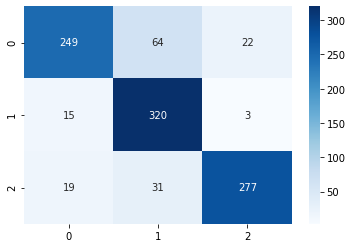

In [45]:
#confusion matrix plot
sns.heatmap(cf_matrix, annot=True,cmap='Blues',fmt="d") #we creatred a heatmap for confusion matrix

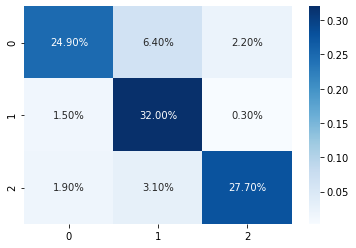

In [38]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') #percentage confusion matrix